# Importando as bibliotecas necessárias

In [ ]:
import pandas as pd
import numpy as np

import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import time
import imblearn
import datetime as DT
import io

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate, RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, IsolationForest, AdaBoostClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances
from sklearn.manifold import TSNE
from sklearn.base import clone
from sklearn.cluster import KMeans, AgglomerativeClustering
from kmodes.kmodes import KModes

from scipy.cluster.hierarchy import dendrogram
from dython.nominal import associations

# Visualizando o Banco de Dados

In [ ]:
mkt = pd.read_csv('Marketing.xls', sep=';')
ord = pd.read_csv('Orders.xls', sep=';')
sess = pd.read_csv('sessions.xls', sep=';')

In [ ]:
sess.head(3)

,session_id,user_account_uuid,session_started,session_ended,install_timestamp,sum_view_restaurant_screen,sum_view_dish_screen,sum_click_add_item,sum_view_checkout,sum_callback_purchase,first_order_has_voucher,media_campaign,load_time,available_restaurants,rownumber
0,0a364c77-4375-4334-8f64-a06bdd22229c,5a2fbdea-e2ee-41a5-b47c-41fbebdc78ef,2020-02-01T00:00:03.924Z,2020-02-01T00:10:51.217Z,NaN,19,5,6,6,7,False,NaN,5.0,462.0,1
1,b01811cd-ad2c-42f1-bccf-b90698ccc7a8,20cb43a7-c90d-4451-b067-e1b934746de6,2020-02-01T00:00:09.616Z,2020-02-01T00:14:22.713Z,NaN,14,1,0,0,0,NaN,NaN,5.0,128.0,2
2,aa453bd1-da47-4cfa-9ce7-a7e2c9227dec,b6bd9094-c2f0-471c-b6ec-9475d8d0591b,2020-02-01T00:00:14.479Z,2020-02-01T00:08:20.102Z,NaN,31,4,4,3,1,False,NaN,6.0,187.0,3


In [ ]:
ord.head(3)

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,...,merchant_long,merchant_lat,has_free_delivery,confirmed_date,concluded_date,lag_last_order,account_id,review_score,nps_score,review_created_at
0,000f4c94-ec38-488b-ad98-9bf3ea19d517,weekday lunch,RESTAURANT,875.0,False,5375.0,0.00,ANDROID,MOBILE,9.39.1,...,-43.38,-22.83,False,2020-02-28T14:07:25.953Z,2020-02-28T16:06:03.701Z,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8,2020-02-28T19:06:31.861Z
1,0018ed39-3ae0-4047-9c9e-fd9a2027e645,weekend dinner,RESTAURANT,0.0,False,2987.5,1250.00,IOS,MOBILE,9.63.0,...,-43.22,-22.93,True,2020-08-21T21:12:23.295Z,2020-08-21T21:59:18.732Z,1.0,407bab9f-f485-48cd-abea-66e6283058c3,5.0,8,2020-09-04T00:14:14.365Z
2,00214248-5a2d-4333-a919-c1f3afd31389,weekday dinner,RESTAURANT,0.0,False,3737.5,2123.75,IOS,MOBILE,9.56.0,...,-46.67,-23.62,True,2020-07-02T20:21:51.900Z,2020-07-02T20:53:39.176Z,3.0,a16865d2-a3ca-4251-afab-083dadeb06e9,5.0,5,2020-07-03T03:49:03.214Z


In [ ]:
mkt.head(3)

,account_id,registration_date,ifood_status,ifood_status_last_month,total_order_count,first_order_date
0,7c0450e7-a806-4208-8449-e4269a27e6b5,2020-02-02,Inactive,Inactive,8,2020-02-28
1,16d0afba-00b8-427a-ba1f-2e397a9fbb54,2016-05-17,Churn,Active,457,2017-03-19
2,61c051ee-d37c-45c6-8c22-c236db3b62b7,2018-09-02,Active,Active,206,2018-09-02


##### juntando os bancos de dados de interesse

In [ ]:
junto = ord.join(mkt.set_index('account_id'), on='account_id')

In [ ]:
junto.head(2)

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,...,lag_last_order,account_id,review_score,nps_score,review_created_at,registration_date,ifood_status,ifood_status_last_month,total_order_count,first_order_date
0,000f4c94-ec38-488b-ad98-9bf3ea19d517,weekday lunch,RESTAURANT,875.0,False,5375.0,0.0,ANDROID,MOBILE,9.39.1,...,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8,2020-02-28T19:06:31.861Z,2019-06-10,Active,Active,216,2019-07-24
1,0018ed39-3ae0-4047-9c9e-fd9a2027e645,weekend dinner,RESTAURANT,0.0,False,2987.5,1250.0,IOS,MOBILE,9.63.0,...,1.0,407bab9f-f485-48cd-abea-66e6283058c3,5.0,8,2020-09-04T00:14:14.365Z,2018-09-29,Active,Active,713,2018-10-14


# Analisando os bancos de dados

In [ ]:
junto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226269 entries, 0 to 226268
Data columns (total 39 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   order_id                 226269 non-null  object 
 1   order_shift              226269 non-null  object 
 2   order_origin             226269 non-null  object 
 3   delivery_fee             226269 non-null  float64
 4   scheduled                226269 non-null  bool   
 5   total_amount             226269 non-null  float64
 6   subsidy_amount           226269 non-null  float64
 7   device_platform          226269 non-null  object 
 8   device_type              226269 non-null  object 
 9   device_app_version       221834 non-null  object 
 10  centroid_id              226269 non-null  object 
 11  state_label              226269 non-null  object 
 12  city                     226269 non-null  object 
 13  district                 226269 non-null  object 
 14  cust

In [ ]:
junto.describe()

,delivery_fee,total_amount,subsidy_amount,customer_long,customer_lat,merchant_zipcode,merchant_long,merchant_lat,lag_last_order,review_score,nps_score,total_order_count
count,226269.000000,226269.000000,226269.000000,226269.000000,226269.000000,2.262690e+05,226269.000000,226269.000000,226085.000000,226269.000000,226269.000000,226269.000000
mean,405.418965,6017.809350,343.687580,-45.693016,-23.192878,1.693620e+07,-45.692937,-23.193716,2.505275,4.666207,9.108150,541.906483
std,504.026635,5180.780032,677.852181,2.184032,2.206372,2.094803e+07,2.194552,2.206171,11.985040,0.928577,1.895903,356.970966
min,-1247.500000,0.000000,-2.500000,-67.870000,-31.780000,0.000000e+00,-67.840000,-31.780000,0.000000,1.000000,1.000000,0.000000
25%,0.000000,2768.750000,0.000000,-46.710000,-23.600000,4.048000e+06,-46.700000,-23.600000,0.000000,5.000000,9.000000,299.000000
50%,0.000000,4500.000000,0.000000,-46.620000,-23.530000,6.473073e+06,-46.620000,-23.540000,1.000000,5.000000,10.000000,474.000000
75%,748.750000,7523.750000,623.750000,-43.350000,-22.940000,2.222003e+07,-43.350000,-22.950000,2.000000,5.000000,10.000000,695.000000
max,5000.000000,174873.750000,19611.250000,-34.820000,2.850000,9.907006e+07,46.790000,2.850000,1429.000000,5.000000,10.000000,3098.000000


##### Criando Variáveis Idade

In [ ]:
now = pd.Timestamp('now')

junto['first_order_date'] = pd.to_datetime(junto['first_order_date'], errors='coerce')
junto['registration_date'] = pd.to_datetime(junto['registration_date'], errors='coerce')

junto['aging_order'] = (now.year*12 + now.month) - \
                       junto.first_order_date.dt.year*12 + junto.first_order_date.dt.month

junto['aging_platform'] = (now.year*12 + now.month) - \
                          junto.registration_date.dt.year*12 + junto.registration_date.dt.month

In [ ]:
junto.head(3)

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,...,review_score,nps_score,review_created_at,registration_date,ifood_status,ifood_status_last_month,total_order_count,first_order_date,aging_order,aging_platform
0,000f4c94-ec38-488b-ad98-9bf3ea19d517,weekday lunch,RESTAURANT,875.0,False,5375.0,0.00,ANDROID,MOBILE,9.39.1,...,5.0,8,2020-02-28T19:06:31.861Z,2019-06-10,Active,Active,216,2019-07-24,48.0,47
1,0018ed39-3ae0-4047-9c9e-fd9a2027e645,weekend dinner,RESTAURANT,0.0,False,2987.5,1250.00,IOS,MOBILE,9.63.0,...,5.0,8,2020-09-04T00:14:14.365Z,2018-09-29,Active,Active,713,2018-10-14,63.0,62
2,00214248-5a2d-4333-a919-c1f3afd31389,weekday dinner,RESTAURANT,0.0,False,3737.5,2123.75,IOS,MOBILE,9.56.0,...,5.0,5,2020-07-03T03:49:03.214Z,2019-11-14,Active,Active,102,2019-11-14,52.0,52


#### Criando lista de métricas e categorias

In [ ]:
metric_feats = ["aging_order","aging_platform","delivery_fee","total_amount","subsidy_amount","lag_last_order","total_order_count"]
cat_feats = ["review_score","nps_score",'order_shift', 'order_origin', 'scheduled', 'device_platform', 'device_type', 'state_label', 'city', 'district', 'dish_type', 'merchant_state', 'merchant_city', 'merchant_district', 'has_free_delivery', 'ifood_status', 'ifood_status_last_month']
cat_feats_small=["review_score","nps_score",'order_shift', 'order_origin', 'scheduled', 'device_platform', 'device_type', 'dish_type', 'has_free_delivery', 'ifood_status', 'ifood_status_last_month']
dt_feats = ['first_order_date','confirmed_date', 'concluded_date','review_created_at', 'registration_date']
ohe_feats = ['x0_weekday breakfast', 'x0_weekday dawn', 'x0_weekday dinner','x0_weekday lunch', 'x0_weekday snack', 'x0_weekend breakfast', 'x0_weekend dawn', 'x0_weekend dinner', 'x0_weekend lunch','x0_weekend snack', 'x1_True', 'x2_ANDROID', 'x2_DESKTOP', 'x2_IOS', 'x3_Active', 'x3_Churn', 'x3_Inactive', 'x3_Reactivated']

##### Plotando Histograma para as métricas

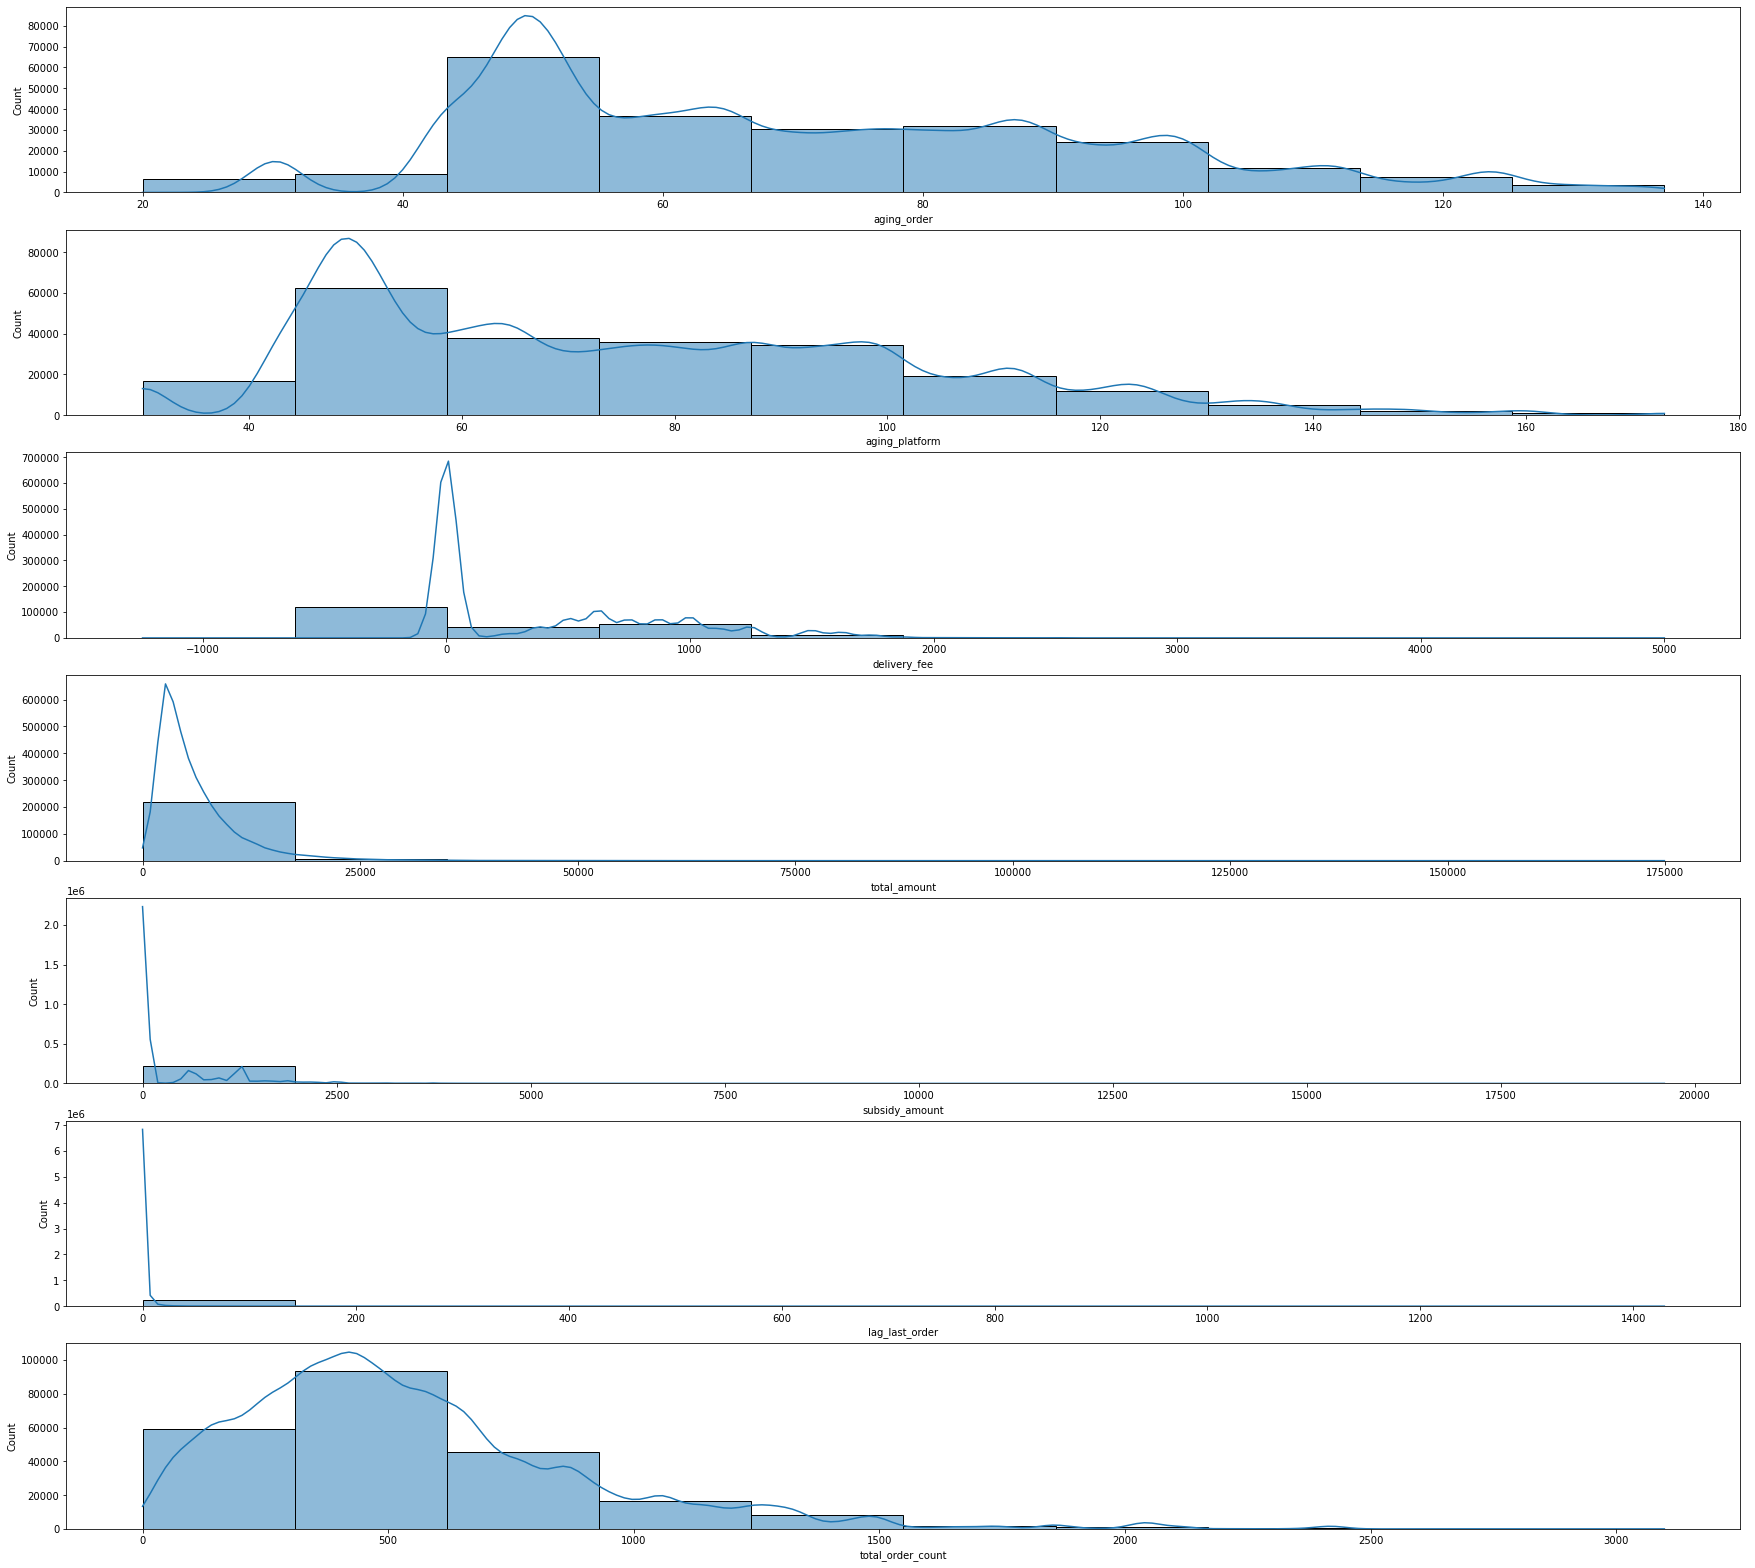

In [ ]:
fig, axs = plt.subplots(nrows = len(metric_feats), figsize = (30, len(metric_feats)*4), sharex= False)

for i, l in enumerate(metric_feats):
  sns.histplot(data=junto[l], bins=10, kde=True, ax = axs[i])

plt.show()

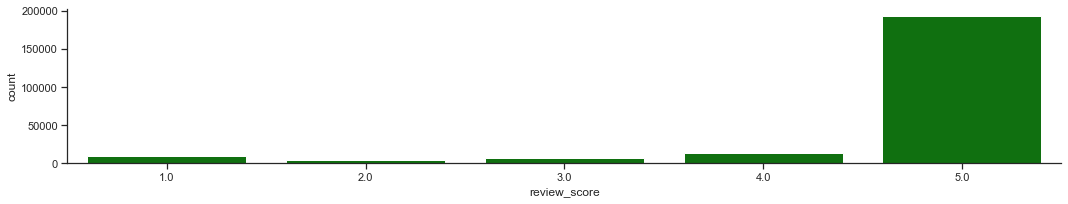

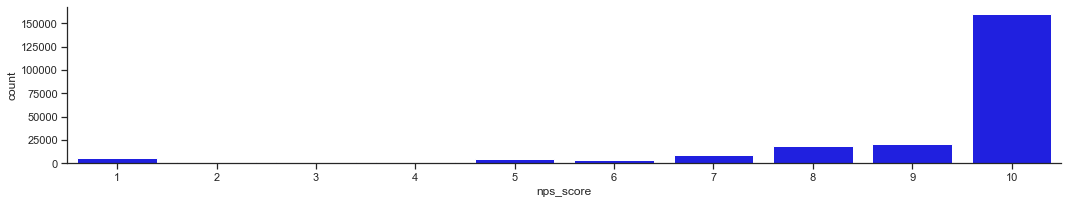

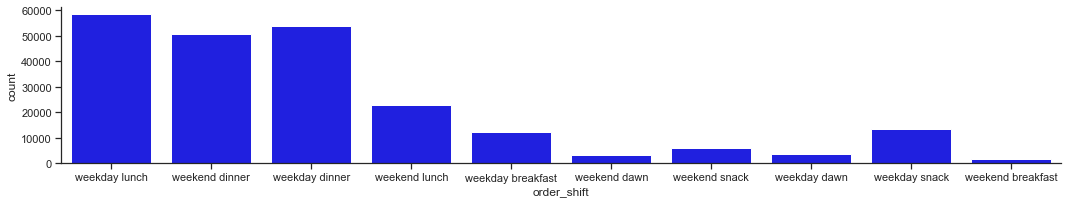

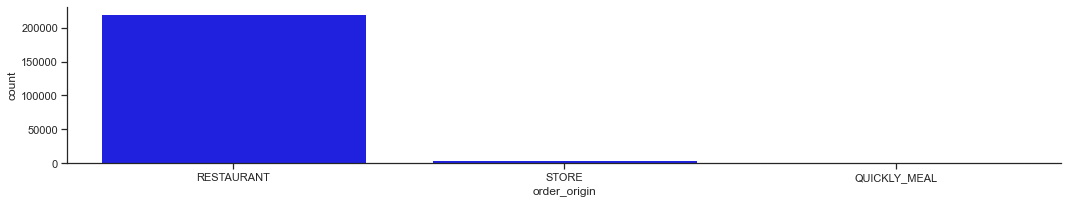

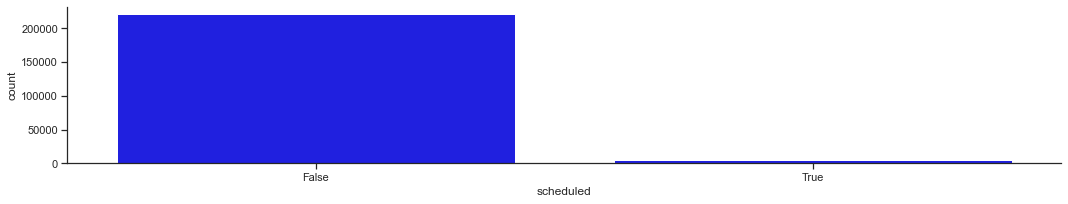

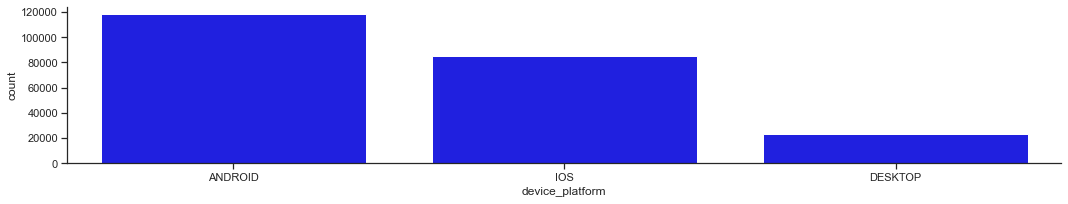

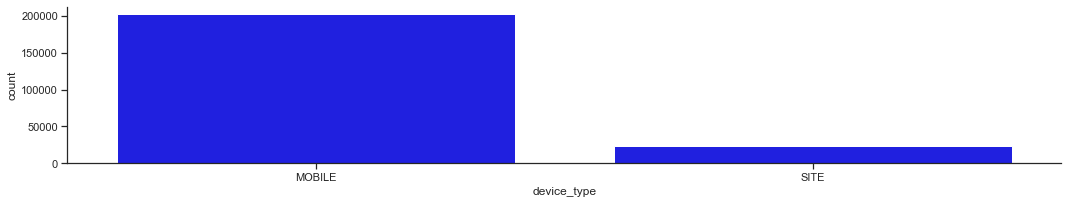

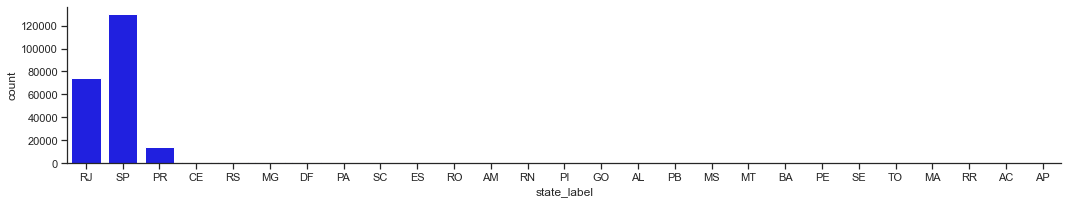

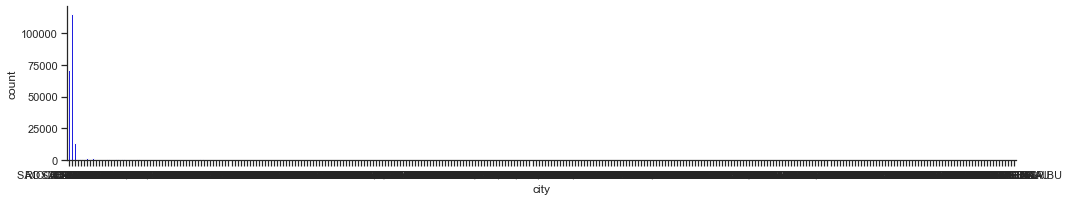

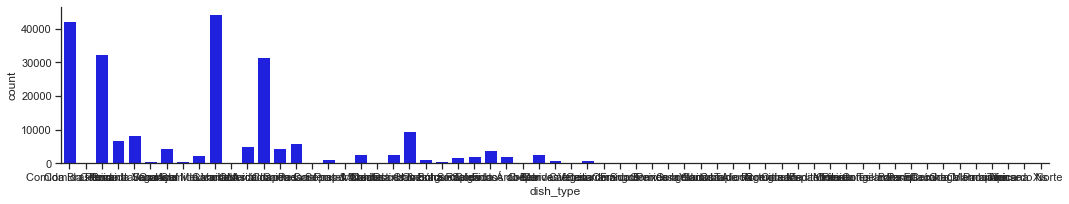

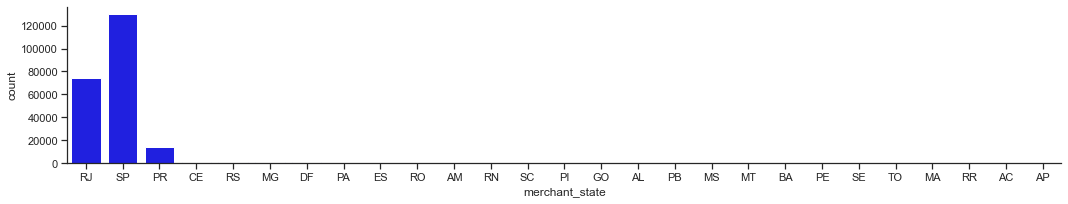

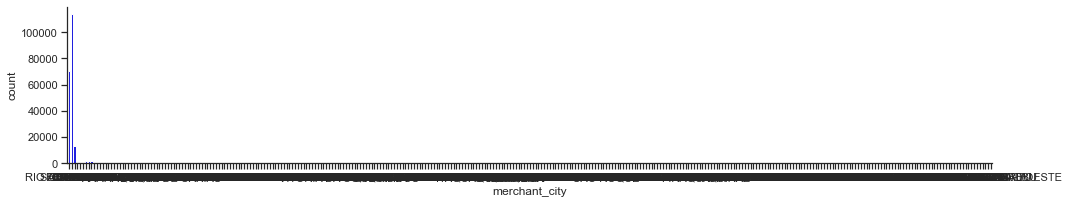

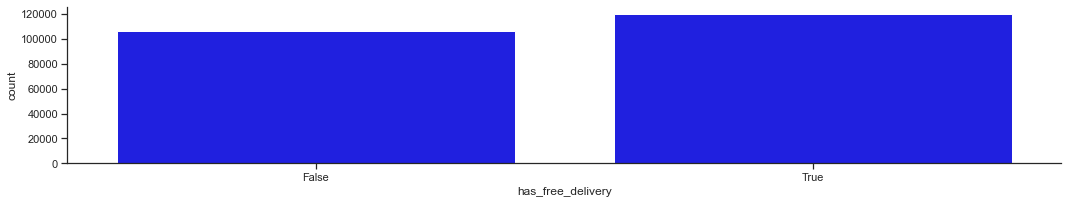

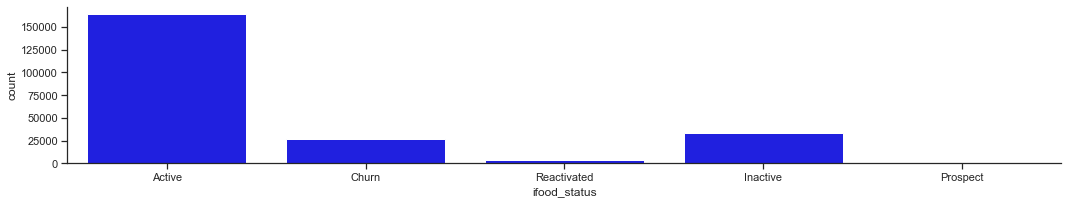

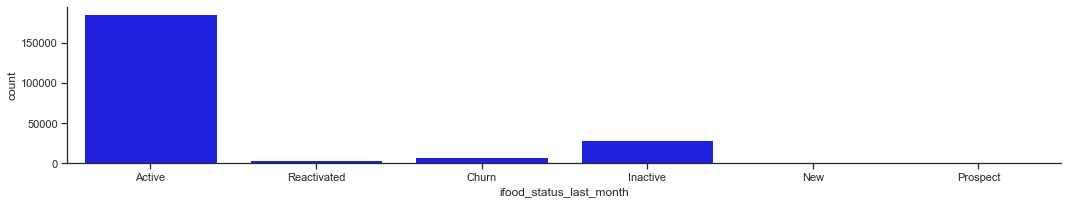

In [ ]:
sns.set_theme(style="ticks", color_codes=True)

fig.set_size_inches(20, 10)

sns.catplot(x="review_score", kind="count", palette=sns.color_palette(['green']),  height=3, aspect=5, data=junto)
sns.catplot(x="nps_score", kind="count", palette=sns.color_palette(['blue']), height=3, aspect=5, data=junto)
sns.catplot(x="order_shift", kind="count", palette=sns.color_palette(['blue']), height=3, aspect=5, data=junto)
sns.catplot(x="order_origin", kind="count", palette=sns.color_palette(['blue']), height=3, aspect=5, data=junto)
sns.catplot(x="scheduled", kind="count", palette=sns.color_palette(['blue']), height=3, aspect=5, data=junto)
sns.catplot(x="device_platform", kind="count", palette=sns.color_palette(['blue']), height=3, aspect=5, data=junto)
sns.catplot(x="device_type", kind="count", palette=sns.color_palette(['blue']), height=3, aspect=5, data=junto)
sns.catplot(x="state_label", kind="count", palette=sns.color_palette(['blue']), height=3, aspect=5, data=junto)
sns.catplot(x="city", kind="count", palette=sns.color_palette(['blue']), height=3, aspect=5, data=junto)
sns.catplot(x="dish_type", kind="count", palette=sns.color_palette(['blue']), height=3, aspect=5, data=junto)
sns.catplot(x="merchant_state", kind="count", palette=sns.color_palette(['blue']), height=3, aspect=5, data=junto)
sns.catplot(x="merchant_city", kind="count", palette=sns.color_palette(['blue']), height=3, aspect=5, data=junto)
sns.catplot(x="has_free_delivery", kind="count", palette=sns.color_palette(['blue']), height=3, aspect=5, data=junto)
sns.catplot(x="ifood_status", kind="count", palette=sns.color_palette(['blue']), height=3, aspect=5, data=junto)
sns.catplot(x="ifood_status_last_month", kind="count", palette=sns.color_palette(['blue']), height=3, aspect=5, data=junto)

### Limpeza dos Dados

In [ ]:
to_drop = ['customer_long','customer_lat', 'merchant_long', 'merchant_lat','first_order_date','registration_date']
junto1 = junto.drop(columns=to_drop)

##### Tirando a "sujeita"

In [ ]:
junto1 = junto1[junto1['merchant_state'].isin(['RJ','SP','PR'])]
junto1 = junto1[junto1['order_origin']=='RESTAURANT']

##### Visualizando o resultado

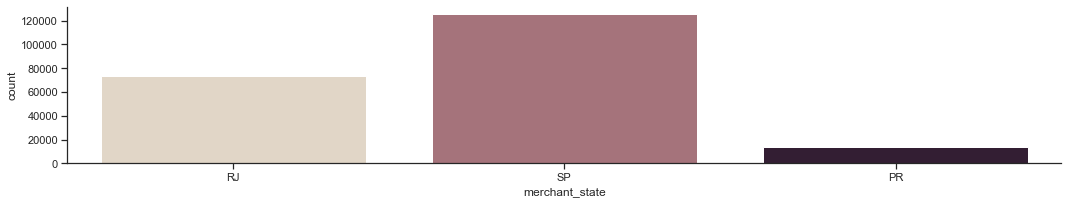

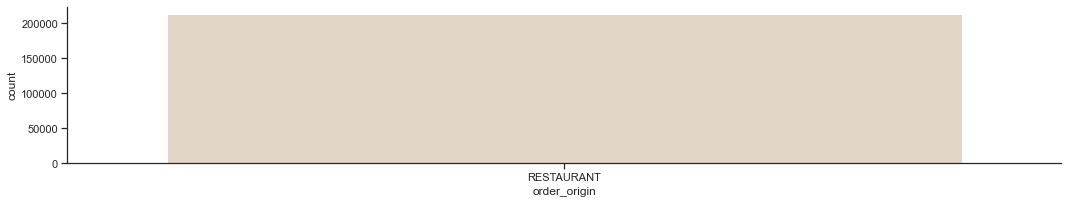

In [ ]:
sns.catplot(x="merchant_state", kind="count", palette="ch:.25", height=3, aspect=5, data=junto1)
sns.catplot(x="order_origin", kind="count", palette="ch:.25", height=3, aspect=5, data=junto1)

In [ ]:
junto1.describe()

,delivery_fee,total_amount,subsidy_amount,merchant_zipcode,lag_last_order,review_score,nps_score,total_order_count,aging_order,aging_platform
count,212650.000000,212650.000000,212650.000000,2.126500e+05,212475.000000,212650.000000,212650.000000,212650.000000,212649.000000,212650.000000
mean,410.891277,5978.902775,341.027839,1.549522e+07,2.504869,4.676055,9.116365,544.845596,70.134927,75.081209
std,504.745946,5153.740159,674.042166,1.920518e+07,12.222237,0.914019,1.884947,358.563438,23.287458,27.152082
min,-1247.500000,0.000000,-2.500000,0.000000e+00,0.000000,1.000000,1.000000,0.000000,20.000000,30.000000
25%,0.000000,2750.000000,0.000000,4.038000e+06,0.000000,5.000000,9.000000,301.000000,50.000000,51.000000
50%,0.000000,4487.500000,0.000000,5.877160e+06,1.000000,5.000000,10.000000,476.000000,65.000000,70.000000
75%,750.000000,7487.500000,623.750000,2.202103e+07,2.000000,5.000000,10.000000,700.000000,87.000000,94.000000
max,5000.000000,174873.750000,9875.000000,8.881506e+07,1429.000000,5.000000,10.000000,3098.000000,137.000000,173.000000


##### Verificando dados duplicados

In [ ]:
junto1[junto1.duplicated(subset=junto1.columns[1:],keep=False)==True].sort_values(by="order_id")

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,...,lag_last_order,account_id,review_score,nps_score,review_created_at,ifood_status,ifood_status_last_month,total_order_count,aging_order,aging_platform


###### Verificando os dados faltantes

In [ ]:
junto1.isnull().sum()

order_id                      0
order_shift                   0
order_origin                  0
delivery_fee                  0
scheduled                     0
total_amount                  0
subsidy_amount                0
device_platform               0
device_type                   0
device_app_version         4403
centroid_id                   0
state_label                   0
city                          0
district                      0
restaurant_id                 0
dish_type                     0
group_id                      0
merchant_centroid_id          0
merchant_state                0
merchant_city                 0
merchant_district             0
merchant_zipcode              0
has_free_delivery             0
confirmed_date               14
concluded_date                4
lag_last_order              175
account_id                    0
review_score                  0
nps_score                     0
review_created_at             0
ifood_status                  0
ifood_st

###### Limpando os dados faltantes

In [ ]:
junto1 = junto1.dropna(subset=['device_app_version'])
junto1 = junto1.dropna(subset=['aging_order'])
junto1 = junto1.dropna(subset=['confirmed_date'])
junto1 = junto1.dropna(subset=['concluded_date'])
junto1 = junto1.dropna(subset=['lag_last_order'])

junto1.reset_index(drop=True, inplace=True)

Verificando o resultado

In [ ]:
junto1.isnull().sum()

order_id                   0
order_shift                0
order_origin               0
delivery_fee               0
scheduled                  0
total_amount               0
subsidy_amount             0
device_platform            0
device_type                0
device_app_version         0
centroid_id                0
state_label                0
city                       0
district                   0
restaurant_id              0
dish_type                  0
group_id                   0
merchant_centroid_id       0
merchant_state             0
merchant_city              0
merchant_district          0
merchant_zipcode           0
has_free_delivery          0
confirmed_date             0
concluded_date             0
lag_last_order             0
account_id                 0
review_score               0
nps_score                  0
review_created_at          0
ifood_status               0
ifood_status_last_month    0
total_order_count          0
aging_order                0
aging_platform

Verificando os outliers

In [ ]:
data = junto1[junto1.columns.intersection(metric_feats)]

IF = IsolationForest(random_state=42)
IF.fit(data)
outl_scores = IF.decision_function(data)
outlier_junto = pd.concat([data, pd.Series(outl_scores, name="outl_score")], axis=1)
outlier_junto.sort_values(by="outl_score", ascending=True)

,delivery_fee,total_amount,subsidy_amount,lag_last_order,total_order_count,aging_order,aging_platform,outl_score
39152,1625.00,21250.00,2500.00,80.0,19,74.0,74,-0.233435
115556,998.75,35098.75,4275.00,6.0,487,133.0,119,-0.216620
108063,0.00,11750.00,2248.75,61.0,648,132.0,132,-0.206062
37055,1750.00,34738.75,0.00,55.0,166,49.0,48,-0.205986
199831,1862.50,8225.00,0.00,140.0,7,31.0,31,-0.204571
...,...,...,...,...,...,...,...,...
123808,0.00,3997.50,0.00,1.0,323,64.0,63,0.135311
144741,0.00,3725.00,0.00,1.0,322,64.0,64,0.135362
108712,0.00,4600.00,0.00,1.0,309,63.0,63,0.135381
132050,0.00,6437.50,0.00,1.0,445,69.0,69,0.135445


<AxesSubplot:xlabel='outl_score', ylabel='Count'>

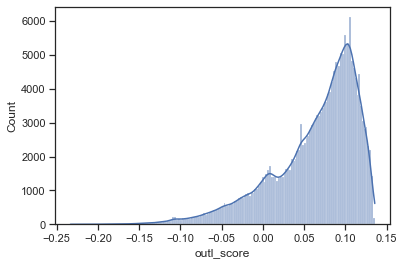

In [ ]:
sns.histplot(data=outlier_junto, x="outl_score", kde=True)

##### One Hot Enconding

In [ ]:
to_ohe = ['order_shift', 'scheduled', 'device_platform', 'ifood_status']
ohe = OneHotEncoder(handle_unknown='error',sparse=False,drop="if_binary")

ohe_feat = ohe.fit_transform(junto1.loc[:,to_ohe])
ohe_df = pd.DataFrame(ohe_feat, index=junto1.index, columns=ohe.get_feature_names())
junto2 = pd.concat([junto1.drop(columns=to_ohe), ohe_df], axis=1)

##### Visualizando correlação

In [ ]:
# Ainda irei avaliar a necessidade 

# Transformações nos "Dtype"

In [ ]:
junto2['total_order_count'] = junto2['total_order_count'].astype(np.float64)
junto2['aging_platform'] = junto2['aging_platform'].astype(np.float64)

In [ ]:
junto2[metric_feats].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208055 entries, 0 to 208054
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   aging_order        208055 non-null  float64
 1   aging_platform     208055 non-null  float64
 2   delivery_fee       208055 non-null  float64
 3   total_amount       208055 non-null  float64
 4   subsidy_amount     208055 non-null  float64
 5   lag_last_order     208055 non-null  float64
 6   total_order_count  208055 non-null  float64
dtypes: float64(7)
memory usage: 11.1 MB


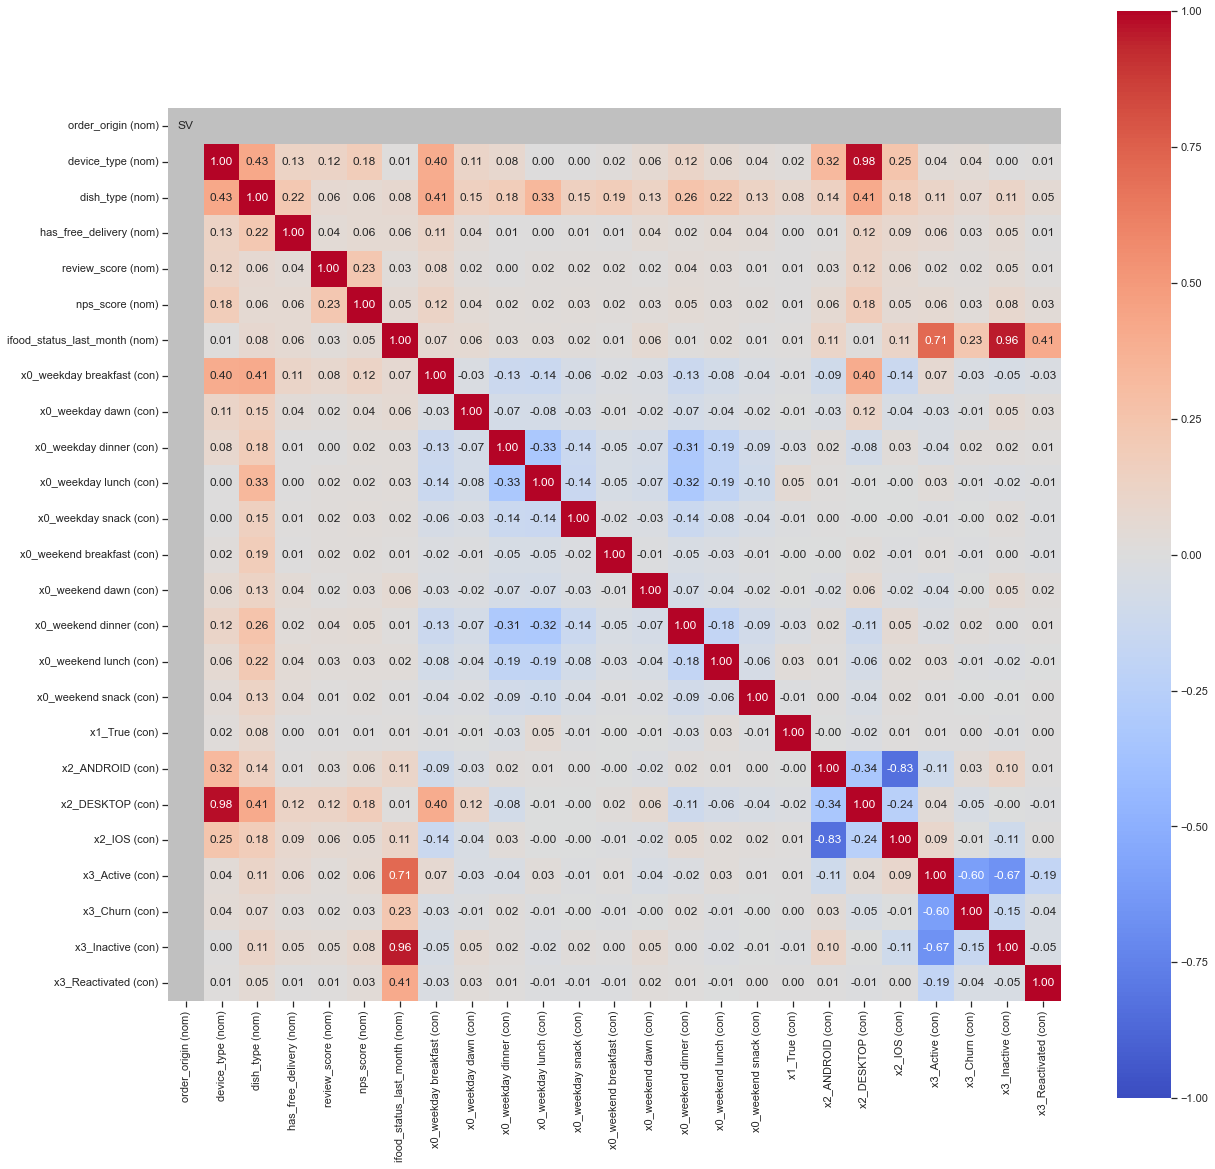

In [ ]:
data = junto2[junto2.columns.intersection(cat_feats_small+ohe_feats)]
corrs, ax = associations(data, mark_columns=True, figsize=(20,20), cmap="coolwarm", nominal_columns=cat_feats)

# Clustering

##### Escolhendo as Feature

Seprando o dataframe por objetivo.
Cada lista vai ter o seu objetivo escrito em seu titulo.

In [ ]:
orders_feats = ['order_shift','order_origin','scheduled','dish_type','ifood_status']
orders_ohe_feats = ['x0_weekday breakfast', 'x0_weekday dawn', 'x0_weekday dinner','x0_weekday lunch', 'x0_weekday snack', 'x0_weekend breakfast', 'x0_weekend dawn', 'x0_weekend dinner', 'x0_weekend lunch','x0_weekend snack', 'x1_True', 'x2_ANDROID', 'x2_DESKTOP', 'x2_IOS','x3_Active', 'x3_Churn', 'x3_Inactive', 'x3_Reactivated']
price_feats = ['delivery_fee','total_amount', 'subsidy_amount','has_free_delivery']
client_feats = ['review_score','lag_last_order', 'nps_score', 'aging_order', 'aging_platform', 'total_order_count']
restaurant_feats = ['group_id','merchant_state']
test = ['total_amount', 'lag_last_order', 'total_order_count']

##### Criando os dataframes

Dataframe com variáveis categóricas

In [ ]:
orders = junto1.loc[:,orders_feats].copy()

Dataframde com variáveis numéricas

In [ ]:
price = junto1.loc[:,price_feats].copy()

Dataframe com variáveis numéricas 2

In [ ]:
client = junto1.loc[:,client_feats].copy()

Dataframe com variáveis categóricas e numéricas

In [ ]:
complete = junto1.loc[:,price_feats+orders_feats+client_feats+restaurant_feats].copy()

Dataframe com variáveis numéricas 3

In [ ]:
price_client = junto1.loc[:,price_feats+client_feats].copy()

Dataframe com variáveis categóricas e numéricas

In [ ]:
price_order = junto1.loc[:,price_feats+orders_feats].copy()

Dataframe com algumas variáveis numéricas

In [ ]:
meio_nu = junto1.loc[:,test].copy()

#### Ato 2: montando o setup para depois começar a brincar de ciência

In [ ]:
scaler = RobustScaler()


price = pd.DataFrame(scaler.fit_transform(price),columns=['delivery_fee','total_amount', 'subsidy_amount','has_free_delivery'])
complete[['delivery_fee','total_amount', 'subsidy_amount','has_free_delivery',"aging_order",'aging_platform',"total_order_count"]] = pd.DataFrame(scaler.fit_transform(complete[['delivery_fee','total_amount', 'subsidy_amount','has_free_delivery',"aging_order",'aging_platform',"total_order_count"]]),columns=['delivery_fee','total_amount', 'subsidy_amount','has_free_delivery',"aging_order",'aging_platform',"total_order_count"])
price_client[['delivery_fee','total_amount', 'subsidy_amount','has_free_delivery',"aging_order",'aging_platform',"total_order_count"]] = pd.DataFrame(scaler.fit_transform(price_client[['delivery_fee','total_amount', 'subsidy_amount','has_free_delivery',"aging_order",'aging_platform',"total_order_count"]]),columns=['delivery_fee','total_amount', 'subsidy_amount','has_free_delivery',"aging_order",'aging_platform',"total_order_count"])
price_order[['delivery_fee','total_amount', 'subsidy_amount','has_free_delivery']] = pd.DataFrame(scaler.fit_transform(price_order[['delivery_fee','total_amount', 'subsidy_amount','has_free_delivery']]))
meio_nu = pd.DataFrame(scaler.fit_transform(meio_nu),columns=[test])

#### PCA - Redução de dimencionalidade

In [ ]:
pca = PCA()
pca_feat = pca.fit_transform(price_client)
cov_matrix = price_client.cov()
pd.DataFrame(pca.components_.T @ np.diag(pca.explained_variance_) @ pca.components_, 
             index=cov_matrix.index, 
             columns=cov_matrix.columns)
pd.DataFrame(price_client.values @ pca.components_.T, 
             index=price_client.index,
             columns=[f"PCA{i}" for i in range(pca.n_components_)])

,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9
0,0.981884,-8.835319,1.316734,0.275314,-0.138270,3.150477,-0.515340,-1.511623,-0.098195,-0.113782
1,0.967575,-8.862520,-0.293070,2.048515,1.275084,2.933573,-0.217192,-0.704123,-0.095025,-0.019226
2,2.988720,-5.962753,-1.280558,2.956951,-0.155989,3.970619,-0.464215,-0.975454,-0.105130,-0.032097
3,-0.030076,-10.817592,1.088265,0.219885,0.571399,2.495725,-0.450594,-1.719336,-0.065347,-0.105524
4,0.977033,-10.891885,0.443577,0.248249,-0.128212,2.672752,-0.568843,-0.303653,-0.066858,0.028807
...,...,...,...,...,...,...,...,...,...,...
208050,1.975440,-10.651847,2.276959,1.012555,0.133727,2.740436,-0.392051,-0.621066,-0.119710,-0.555891
208051,0.974015,-10.588213,2.188698,1.025795,0.720821,2.391882,-1.748479,-1.245967,-0.223073,-0.110849
208052,1.968396,-10.570389,2.522430,1.150952,1.125838,2.409072,-1.086926,-1.141201,-0.176027,-0.142470
208053,0.989421,-1.802434,-0.505720,1.244054,1.052867,3.464108,-1.095192,-0.421000,-0.167465,0.008288


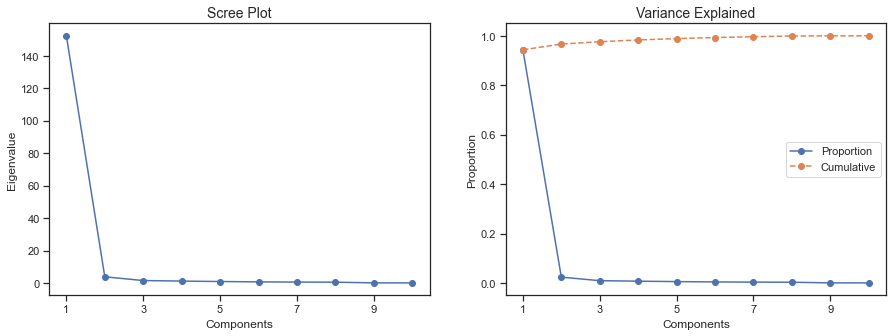

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

##### Número de componentes a serem retidos

In [ ]:
pca = PCA(n_components=2)
pca_feat = pca.fit_transform(price_client)
pca_feat_names = [f"PCA{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=price_order.index, columns=pca_feat_names)

Retribuindo o dataframe para conter as variaveis com PCA

In [ ]:
df_pca = pd.concat([price_client, pca_df], axis=1)

def _color_red_or_green(val):
    if val < -0.5:
        color = 'background-color: red'
    elif val > 0.5:
        color = 'background-color: green'
    else:
        color = ''
    return color               

Interpretando cada Componente Principal

In [ ]:
loadings = df_pca.corr().loc[price_client.columns,pca_feat_names]
loadings
loadings.style.applymap(_color_red_or_green)

,PCA0,PCA1
delivery_fee,0.005773,0.101162
total_amount,0.019090,0.158491
subsidy_amount,-0.000068,0.032004
has_free_delivery,-0.008286,-0.082399
review_score,-0.029595,-0.477914
lag_last_order,1.000000,-0.000382
nps_score,-0.012242,-0.991563
aging_order,-0.017980,0.193923
aging_platform,-0.011134,0.190606
total_order_count,-0.131070,-0.006157


#### Avaliando o número de Clusters

Definindo uma função para métricas de qualidade

In [ ]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # Retorna a soma dos quadrados (SS) para cada variável

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust     

Definindo função para criação de perfil de cluster

In [ ]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtrando df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Obtendo os centróides e contando...
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Ajustando os dados
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Ajustando o layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-50)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Profilling", fontsize=23)
    plt.show()

Criando uma função para traçar o dendograma correspondente de um cluster hierárquico usando AgglomerativeClustering e o método de dendrograma disponível na scipy. 

In [ ]:
def plot_dendrogram(hclust):
    # create the counts of samples under each node (number of points being merged)
    counts = np.zeros(hclust.children_.shape[0])
    n_samples = len(hclust.labels_)

    # hclust.children_ contains the observation ids that are being merged
    # At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
    for i, merge in enumerate(hclust.children_):
        # track the number of observations in the current cluster being formed
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                # If this is True, then we are merging an observation
                current_count += 1  # leaf node
            else:
                # Otherwise, we are merging a previously formed cluster
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
    # the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
    # the counts indicate the number of points being merged (dendrogram's x-axis)
    linkage_matrix = np.column_stack(
        [hclust.children_, hclust.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    sns.set()
    fig = plt.figure(figsize=(11,5))
    # The Dendrogram parameters need to be tuned
    
    y_threshold = 25
    dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
    plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
    plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
    plt.xlabel('Number of points in node (or index of point if no parenthesis)')
    plt.ylabel(f'{distance.title()} Distance', fontsize=13)
    plt.show()

##### Set up dos Clusterers

In [ ]:
kmeans = KMeans(init='k-means++', n_init=10, random_state=42)

hierarchical = AgglomerativeClustering(affinity='euclidean')

Para obter o R² para cada solução de cluster em variáveis demográficas

Houve erro aqui - voltar aqui para resolver

In [ ]:
df_sample = meio_nu.sample(frac = 0.25)

Erro ocorre aparti daqui

In [ ]:
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_sample, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_sample, hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

,kmeans,complete,average,single,ward
2,0.549716,0.539975,0.539975,0.490382,0.539975
3,0.746203,0.560258,0.560258,0.497449,0.746159
4,0.818719,0.648793,0.684144,0.563373,0.804449
5,0.867859,0.784223,0.687259,0.564591,0.856282
6,0.891892,0.787338,0.700612,0.600022,0.877870
7,0.906603,0.795744,0.702688,0.655203,0.898153
8,0.920185,0.797820,0.703907,0.655355,0.917001
9,0.933467,0.799039,0.841466,0.664263,0.931493


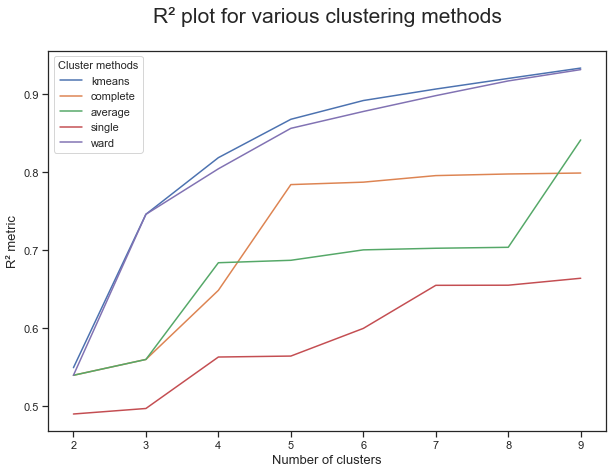

In [ ]:
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("R² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

-----------------------

In [ ]:
#plota o dendograma

linkage = 'ward'
distance = 'euclidean' 
alust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
alust.fit_predict(df_sample)

array([52013, 37441, 39883, ...,     5,     2,     0], dtype=int64)

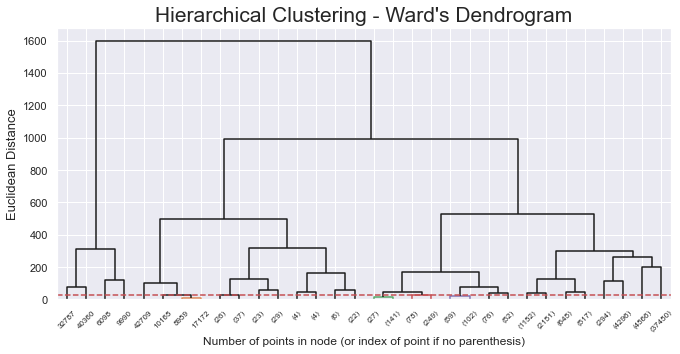

In [ ]:
plot_dendrogram(alust)

##### Observando a Inércia de n clusters usados.

In [ ]:
range_clust = list(range(1,6))
inertia = []
for n_clus in range_clust:  # iterar sobre o intervalo de ncluster desejado
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=10, random_state=42)
    kmclust.fit(df_sample)
    inertia.append(kmclust.inertia_)  # salva a inércia da solução de cluster fornecida

inertia = dict(zip(range_clust,inertia))

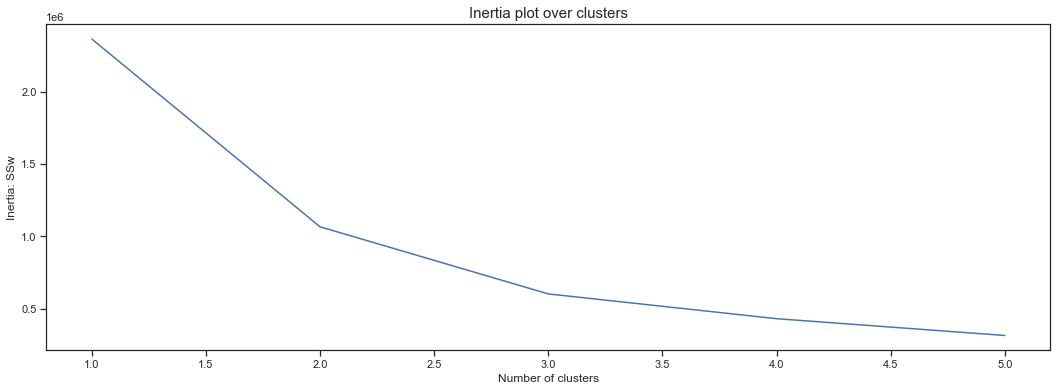

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(pd.Series(inertia))
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

Observação da Silhouette Score

For n_clusters = 2, the average silhouette_score is : 0.9944056488021709
For n_clusters = 3, the average silhouette_score is : 0.952292851998643
For n_clusters = 4, the average silhouette_score is : 0.8543672357350397
For n_clusters = 5, the average silhouette_score is : 0.8452761320403427


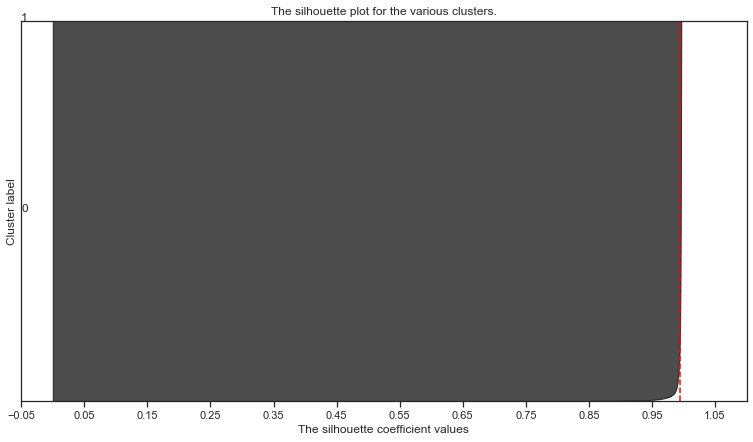

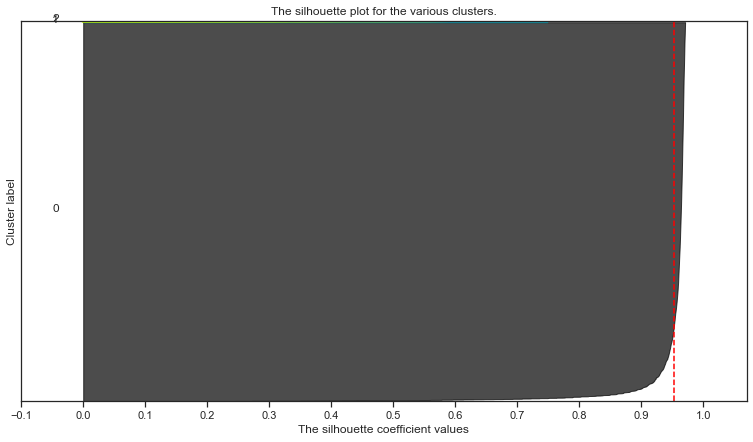

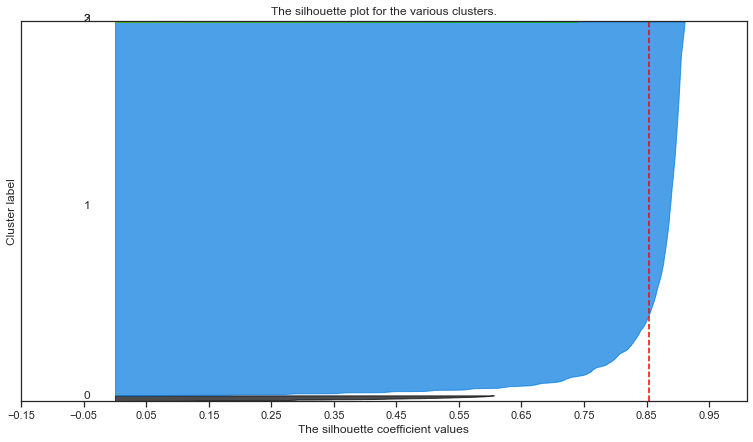

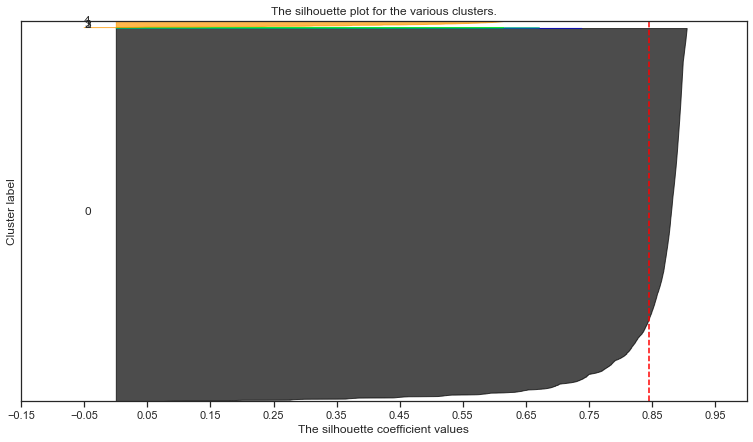

In [ ]:
df_sill = df_sample.copy()

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clust:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=10, random_state=42)
    cluster_labels = kmclust.fit_predict(df_sill)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_sill, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_sill, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df_sill) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

##### Estágio Final

Número de Clusters a ser usado

In [ ]:
#n_clusters = 3

Aplicando K-Means para o número de clusters definidos

In [ ]:
kmclust = KMeans(n_clusters=2, init='k-means++', n_init=5, random_state=42,verbose=0)
km_labels = kmclust.fit_predict(df_sample)

##### Visualização TSNE

Após um inesperado erro em alguns codigos, o TSE pode aparecer alguns erros incomuns em sua visualização.

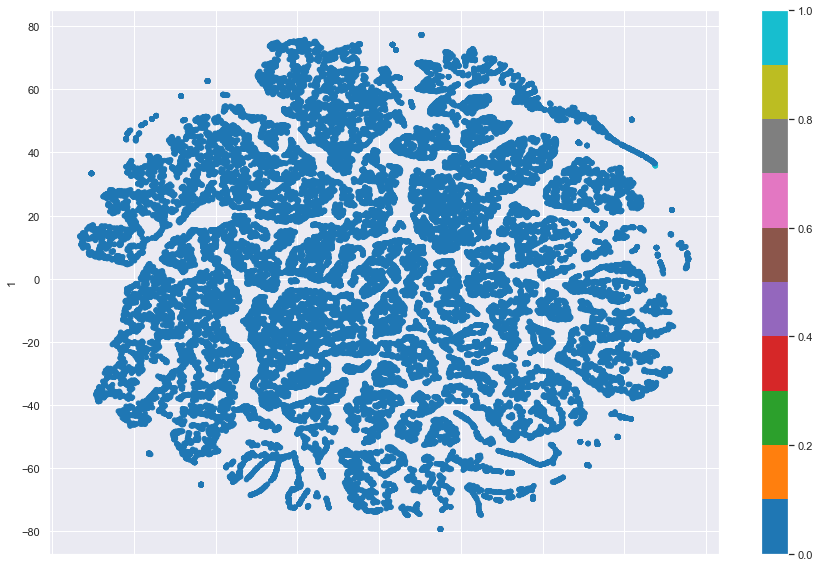

In [ ]:
df_TSNE = TSNE().fit_transform(df_sample)
pd.DataFrame(df_TSNE).plot.scatter(x=0, y=1, c=km_labels, colormap='tab10', figsize=(15,10))
plt.show()

##### Profiling

In [ ]:
df_prof = pd.concat([df_sample.loc[:,test],pd.Series(km_labels,name="labels")],axis=1)
df_prof.groupby("labels").mean()

,"(total_amount,)","(lag_last_order,)","(total_order_count,)"
labels,,,
0.0,0.301069,0.729793,0.159443
1.0,-0.110933,1.500000,-0.381679
2.0,0.216828,0.447368,0.547342


In [ ]:
order = dict(zip(df_prof.groupby("labels").size().sort_values(ascending=False).index, [i for i in range(0,8)]))
df_prof["labels"] = df_prof["labels"].replace(order)                 

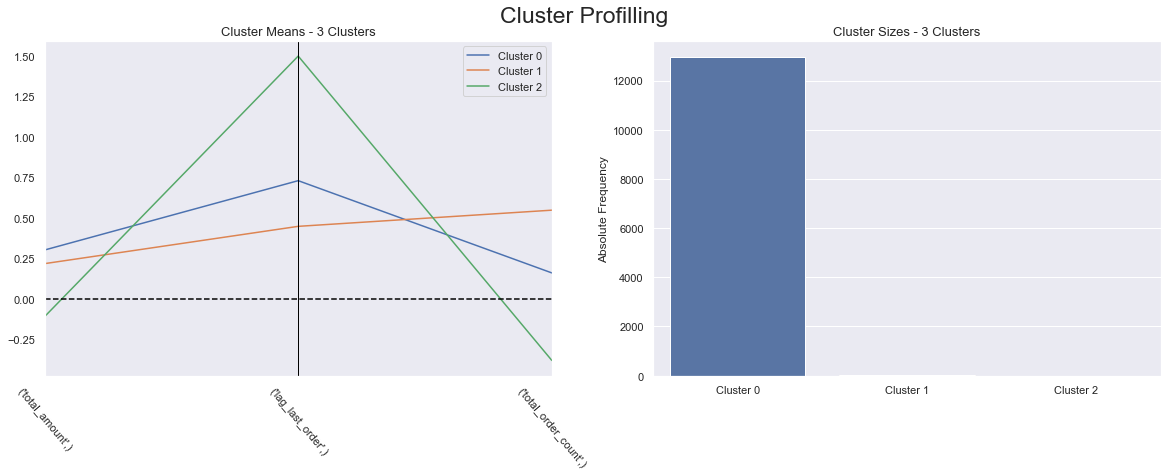

In [ ]:
cluster_profiles(df = df_prof, label_columns = ['labels'], figsize = (20, 6),)    

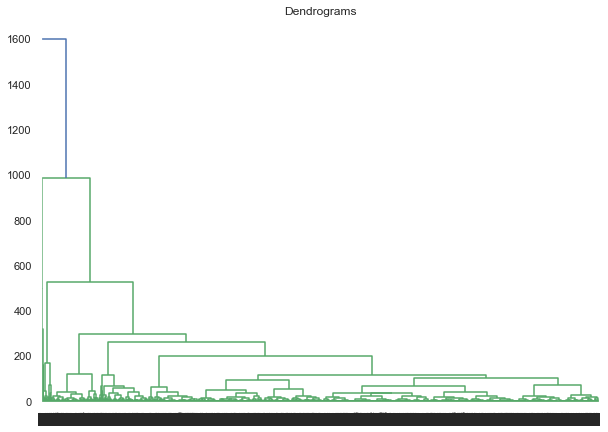

In [ ]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(df_sample, method='ward'))

In [ ]:
linkage = 'ward'
distance = 'euclidean'
aclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=None, n_clusters=3)
aclust.fit_predict(df_sample)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

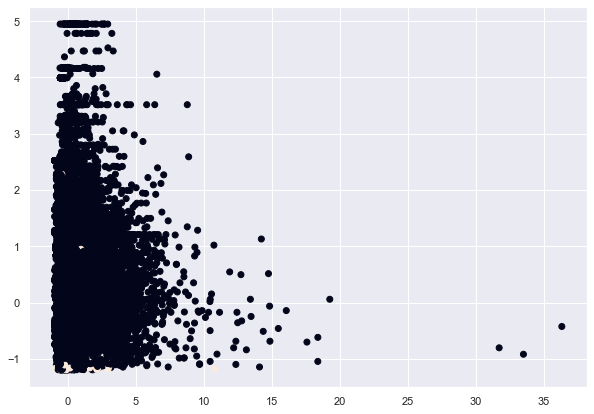

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(df_sample['total_amount'], df_sample['total_order_count'],  c=aclust.labels_)


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 850775.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 850775.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5808, cost: 812149.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 86114, cost: 740331.0
Run 2, iteration: 2/100, moves: 4334, cost: 740331.0
Best run was number 2
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 47689, cost: 714485.0
Run 1, iteration: 2/100, moves: 7430, cost: 714485.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 68649, cost: 689750.0
Run 2, iteration: 2/100, moves: 657, cost: 689750.0
Bes

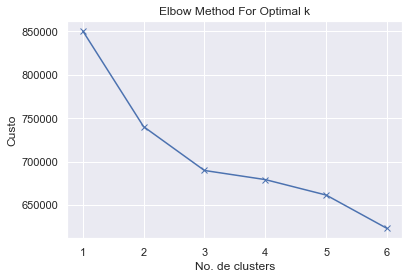

In [ ]:
cost = []
K = range(1,7)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 2, verbose=1)
    kmode.fit_predict(price_order)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. de clusters')
plt.ylabel('Custo')
plt.title('Elbow Method For Optimal k')
plt.show()

# Conclusão:

O numero de Clusters que pode ser usado é no maximo de 3, porem.. pode não ser muito util, fazendo assim o numero recomendo ser de 2 clusters e no maximo 3 (caso nescessario)

Ao realizar esse projetinho do desafio da Ifood, apresenta "problemas" de uma possivel alta dimensionalidade nas variaveis do grupo "price_client", trazendo em momentos anteriores apenas um cluster visivel no T-SNE.

------------

Esse projeto é apenas um experimento e um treino para aprender mais sobre Data Science. Eu aceito criticas e dicas de como melhorar esse projeto :)